In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_train_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_train_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:


model = NeuralNetwork(
    in_features=TS_IN_FEATURES, 
    units=512,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM,
    n_blocks=4,
    n_stacks=3,
    dropout=0.3
)

print(model)

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=512, bias=True)
  (embedding_output): Linear(in_features=512, out_features=1, bias=True)
  (cont_input): Linear(in_features=4, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (stacks): ModuleList(
    (0): NeuralStack(
      (blocks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=516, out_features=516, bias=True)
          (layer2): Linear(in_features=516, out_features=516, bias=True)
          (layer3): Linear(in_features=516, out_features=516, bias=True)
          (layer4): Linear(in_features=516, out_features=516, bias=True)
          (fwr_layer): Linear(in_features=516, out_features=516, bias=True)
          (output): Linear(in_features=516, out_features=516, bias=True)
          (res_layer): Linear(in_features=516, out_features=516, bias=True)
          (res

# Loop throug each stock
Create Trainer only once

Using cuda-device
Start training for stock: 1301


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: <<< 0 >>>

                    Average train loss: 1.5030711669921875 | 
                    Train-Mae: 165.4462127685547 |

                    Average val loss: 51.093509674072266|
                    Val-Mae: 4.572481155395508
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.26875469970703125 | 
                    Train-Mae: 5.56298303604126 |

                    Average val loss: 0.5037978291511536|
                    Val-Mae: 0.585794985294342
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.1761517333984375 | 
                    Train-Mae: 5.735794544219971 |

                    Average val loss: 0.4150189757347107|
                    Val-Mae: 0.542933464050293
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average train 

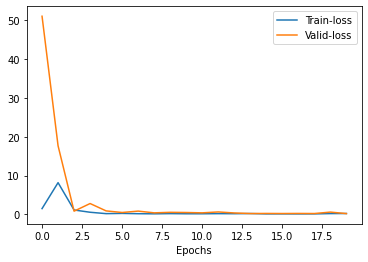

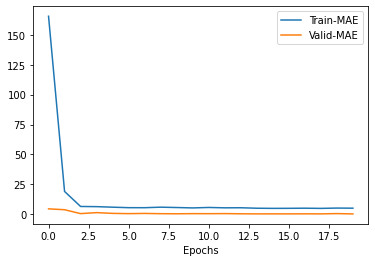

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.01252110195159912 | 
                    Train-Mae: 2.4467227458953857 |

                    Average val loss: 1.5225129127502441|
                    Val-Mae: 0.9872331023216248
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.010053566932678223 | 
                    Train-Mae: 2.3952596187591553 |

                    Average val loss: 1.9084668159484863|
                    Val-Mae: 1.1689099073410034
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.012402406692504883 | 
                    Train-Mae: 2.4127988815307617 |

                    Average val loss: 2.4334208965301514|
                    Val-Mae: 1.3610689640045166
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Ave

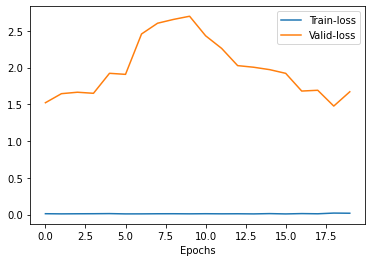

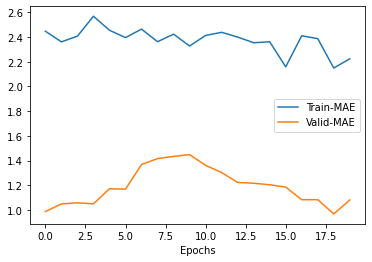

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.050460235595703125 | 
                    Train-Mae: 4.894255638122559 |

                    Average val loss: 5.404743194580078|
                    Val-Mae: 2.1987271308898926
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.04267116546630859 | 
                    Train-Mae: 4.5363850593566895 |

                    Average val loss: 3.882627010345459|
                    Val-Mae: 1.660952091217041
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.05688905334472656 | 
                    Train-Mae: 4.59926700592041 |

                    Average val loss: 6.24121618270874|
                    Val-Mae: 2.4175963401794434
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average trai

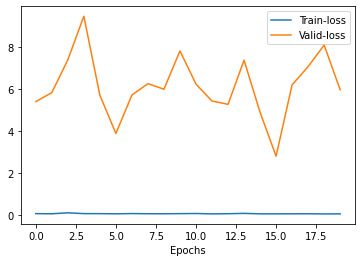

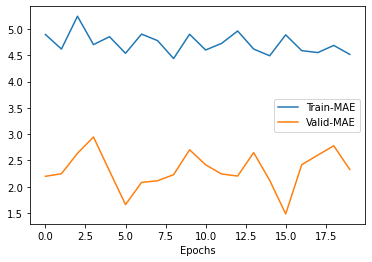

####################

Start training for stock: 1376
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.07934837341308594 | 
                    Train-Mae: 5.212655544281006 |

                    Average val loss: 1.4008331298828125|
                    Val-Mae: 0.8828170895576477
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.14103445434570314 | 
                    Train-Mae: 5.552135467529297 |

                    Average val loss: 1.3353976011276245|
                    Val-Mae: 0.9103477001190186
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.07426548767089844 | 
                    Train-Mae: 4.874166011810303 |

                    Average val loss: 1.5023337602615356|
                    Val-Mae: 1.053335189819336
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average t

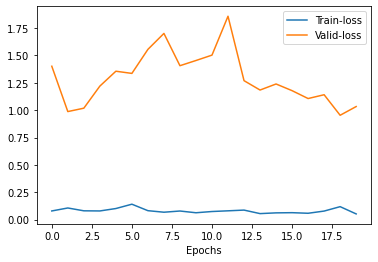

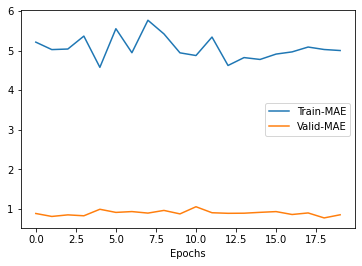

####################

Start training for stock: 1377
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.022712966918945313 | 
                    Train-Mae: 3.050318717956543 |

                    Average val loss: 1.0706225633621216|
                    Val-Mae: 0.8128019571304321
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.03570079803466797 | 
                    Train-Mae: 3.0815649032592773 |

                    Average val loss: 0.8988500237464905|
                    Val-Mae: 0.7568572163581848
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.037236804962158206 | 
                    Train-Mae: 3.274664878845215 |

                    Average val loss: 1.1709389686584473|
                    Val-Mae: 0.8712974786758423
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Avera

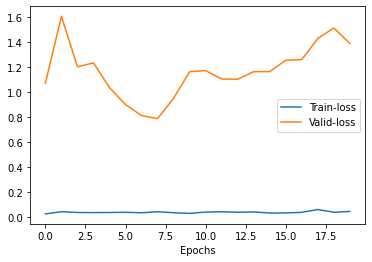

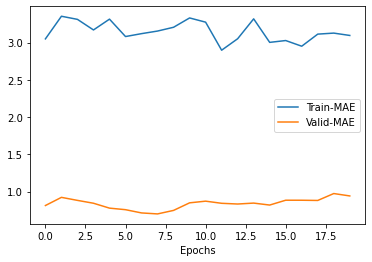

####################

Start training for stock: 1379
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.037039241790771484 | 
                    Train-Mae: 4.988103866577148 |

                    Average val loss: 1.8955377340316772|
                    Val-Mae: 1.1670520305633545
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.026841365814208984 | 
                    Train-Mae: 4.508847236633301 |

                    Average val loss: 0.9281489253044128|
                    Val-Mae: 0.7046846747398376
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.021941171646118165 | 
                    Train-Mae: 3.9506566524505615 |

                    Average val loss: 0.8087660074234009|
                    Val-Mae: 0.651228666305542
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Avera

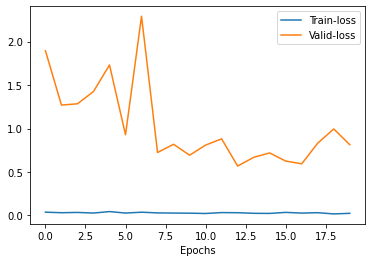

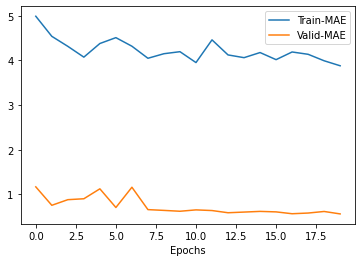

####################

Start training for stock: 1381
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.10534500885009766 | 
                    Train-Mae: 3.2479515075683594 |

                    Average val loss: 0.17724333703517914|
                    Val-Mae: 0.2876490652561188
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.09273892211914063 | 
                    Train-Mae: 3.2930808067321777 |

                    Average val loss: 0.1336153894662857|
                    Val-Mae: 0.2724454700946808
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.20141159057617186 | 
                    Train-Mae: 4.387819766998291 |

                    Average val loss: 1.0353024005889893|
                    Val-Mae: 0.840482771396637
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Averag

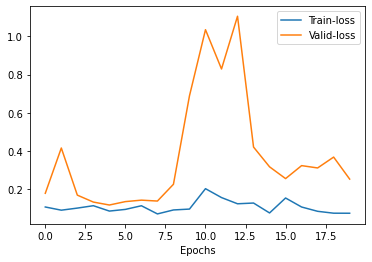

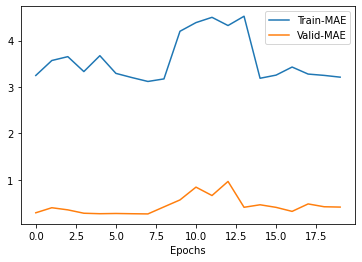

####################

Start training for stock: 1407
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.04066244506835937 | 
                    Train-Mae: 4.061240196228027 |

                    Average val loss: 109.17479705810547|
                    Val-Mae: 8.29285717010498
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.05774516296386719 | 
                    Train-Mae: 3.6785402297973633 |

                    Average val loss: 62.77472686767578|
                    Val-Mae: 7.238903999328613
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.03445038604736328 | 
                    Train-Mae: 3.4656405448913574 |

                    Average val loss: 35.58487319946289|
                    Val-Mae: 5.64382791519165
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average train

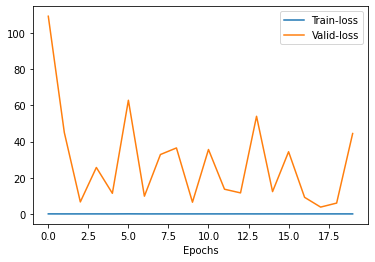

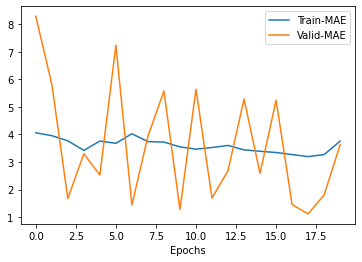

####################

Start training for stock: 1414
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.015143254280090331 | 
                    Train-Mae: 3.7292726039886475 |

                    Average val loss: 0.643862247467041|
                    Val-Mae: 0.675576388835907
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.01462144660949707 | 
                    Train-Mae: 3.736330270767212 |

                    Average val loss: 0.31042876839637756|
                    Val-Mae: 0.4039459228515625
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.014864355087280274 | 
                    Train-Mae: 3.6677725315093994 |

                    Average val loss: 0.4068269431591034|
                    Val-Mae: 0.48961085081100464
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Aver

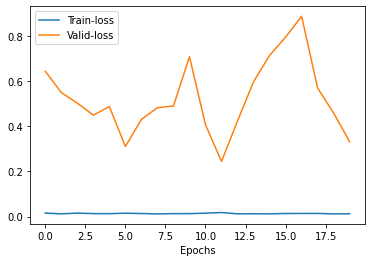

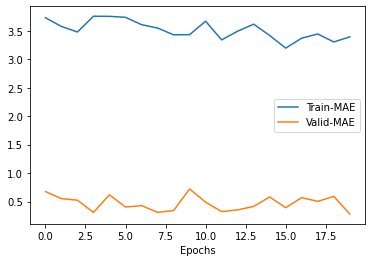

####################

Start training for stock: 1417
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.01448317813873291 | 
                    Train-Mae: 1.3585691452026367 |

                    Average val loss: 4.480521202087402|
                    Val-Mae: 0.9409146904945374
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.01579919719696045 | 
                    Train-Mae: 1.4314789772033691 |

                    Average val loss: 2.483212471008301|
                    Val-Mae: 0.7198384404182434
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.018340978622436523 | 
                    Train-Mae: 1.5155876874923706 |

                    Average val loss: 3.1572041511535645|
                    Val-Mae: 0.6553928256034851
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Averag

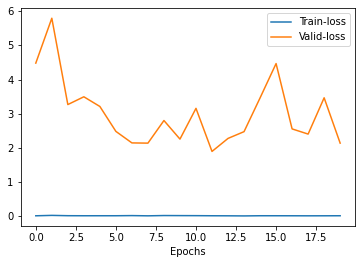

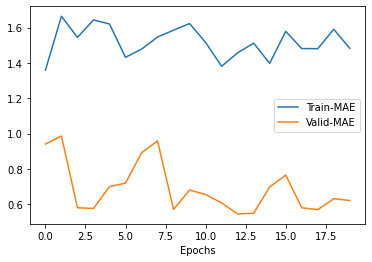

####################

Start training for stock: 1419
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.01778124237060547 | 
                    Train-Mae: 3.1565330028533936 |

                    Average val loss: 9.361759185791016|
                    Val-Mae: 2.4774580001831055
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.01510332202911377 | 
                    Train-Mae: 3.0903759002685547 |

                    Average val loss: 16.867517471313477|
                    Val-Mae: 1.991478681564331
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.014981061935424804 | 
                    Train-Mae: 3.3627521991729736 |

                    Average val loss: 7.679502964019775|
                    Val-Mae: 1.0019081830978394
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average

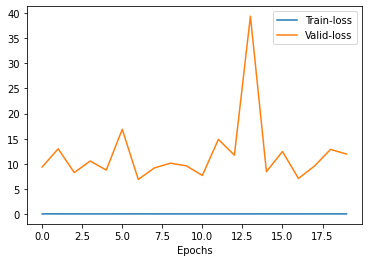

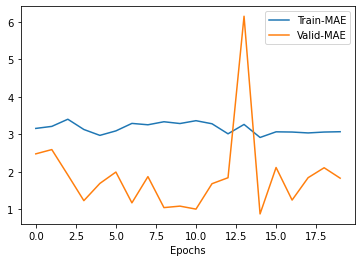

####################

Start training for stock: 1429
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.02828302764892578 | 
                    Train-Mae: 3.1918699741363525 |

                    Average val loss: 1.0531774759292603|
                    Val-Mae: 0.5943183898925781
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.028966815948486328 | 
                    Train-Mae: 3.0836591720581055 |

                    Average val loss: 2.729942798614502|
                    Val-Mae: 0.505630373954773
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.02994635009765625 | 
                    Train-Mae: 3.2500157356262207 |

                    Average val loss: 3.390476942062378|
                    Val-Mae: 1.404465913772583
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Average 

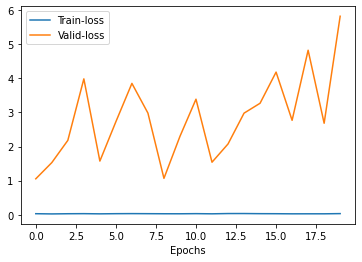

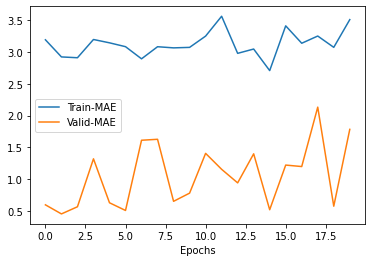

####################

Start training for stock: 1435
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.01761197280883789 | 
                    Train-Mae: 2.6052258014678955 |

                    Average val loss: 0.4917582869529724|
                    Val-Mae: 0.173231303691864
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.014850768089294433 | 
                    Train-Mae: 2.5486137866973877 |

                    Average val loss: 0.26860859990119934|
                    Val-Mae: 0.38452503085136414
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.012170753479003905 | 
                    Train-Mae: 2.568751096725464 |

                    Average val loss: 0.2444152683019638|
                    Val-Mae: 0.31637322902679443
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Av

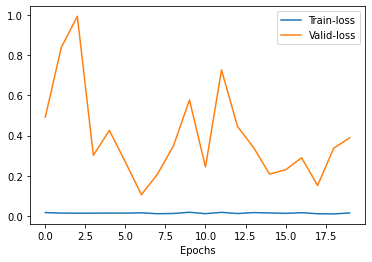

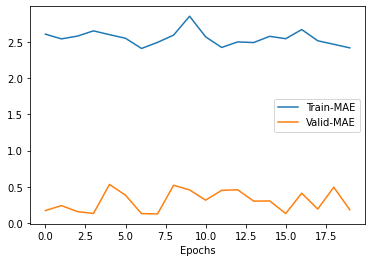

####################

Start training for stock: 1515
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.025059598922729492 | 
                    Train-Mae: 2.5321712493896484 |

                    Average val loss: 0.6375738382339478|
                    Val-Mae: 0.34326186776161194
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.02454311752319336 | 
                    Train-Mae: 2.5224790573120117 |

                    Average val loss: 0.4531853199005127|
                    Val-Mae: 0.43665406107902527
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.024126203536987304 | 
                    Train-Mae: 2.4627227783203125 |

                    Average val loss: 0.4107503592967987|
                    Val-Mae: 0.492823988199234
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Av

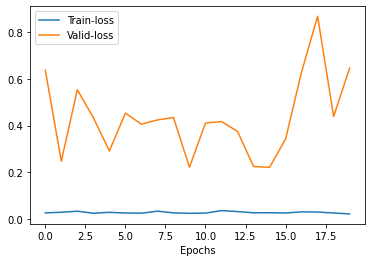

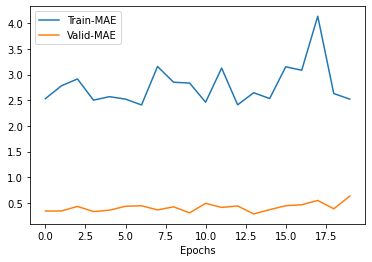

####################

Start training for stock: 1518
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.010715655326843262 | 
                    Train-Mae: 2.4649250507354736 |

                    Average val loss: 1.2239573001861572|
                    Val-Mae: 0.7013088464736938
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.011209378242492676 | 
                    Train-Mae: 2.4981846809387207 |

                    Average val loss: 3.198970317840576|
                    Val-Mae: 0.8042781949043274
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.009959502220153809 | 
                    Train-Mae: 2.486983299255371 |

                    Average val loss: 1.992289662361145|
                    Val-Mae: 0.730394721031189
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Averag

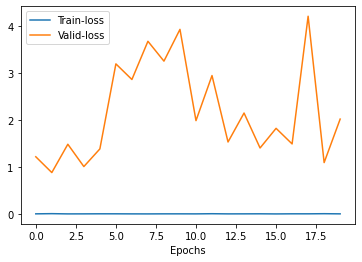

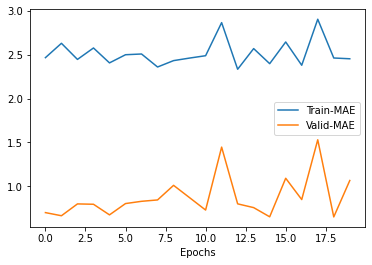

####################

Start training for stock: 1605
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.014239877700805663 | 
                    Train-Mae: 2.4174904823303223 |

                    Average val loss: 3.2793490886688232|
                    Val-Mae: 0.9685730934143066
                    
.................... End of epoch 0 ....................
Epoch: <<< 5 >>>

                    Average train loss: 0.014152912139892579 | 
                    Train-Mae: 2.223918914794922 |

                    Average val loss: 1.7057082653045654|
                    Val-Mae: 1.0464756488800049
                    
.................... End of epoch 5 ....................
Epoch: <<< 10 >>>

                    Average train loss: 0.010916391372680663 | 
                    Train-Mae: 2.427197217941284 |

                    Average val loss: 1.285976767539978|
                    Val-Mae: 0.8823809623718262
                    
.................... End of epoch 10 ....................
Epoch: <<< 15 >>>

                    Avera

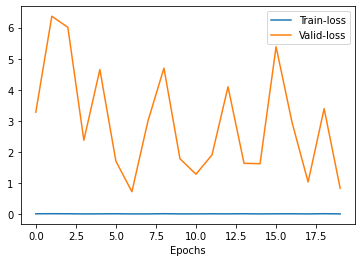

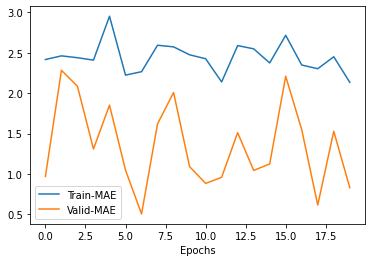

####################

CPU times: total: 15min 12s
Wall time: 15min 15s


In [6]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512
weight_decay = 0.0001

trainer = Trainer(model, optimizer_name='rmsprop', lr=1.3333e-5, weight_decay=weight_decay)
torch.autograd.set_detect_anomaly(True)

for s in stocks:
    train_loader, val_dataloader = None, None
    if count > 15:
        break
    print(f'Start training for stock: {s}')

    train_dataloader, val_dataloader = dataloader_by_stock(
        train_df, s, batch_size=BATCH_SIZE, continous_cols=CONT_COLS)

    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=20
    )
    print('#' * 20)
    print()
    count += 1
    
trainer.save_model(model)

    